In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from module import FlowMatchingModel 

In [4]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG/checkpoints/best-model-epoch=95-val_loss=0.000676.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG/checkpoints/best-model-epoch=95-val_loss=0.000676.ckpt


In [16]:
def predict_star_map(total_mass_map,condition=None,num_steps=100):

    # Convert to tensor: (1, 1, H, W)
    input_tensor = torch.FloatTensor(total_mass_map).unsqueeze(0).unsqueeze(0).to(device)

    if condition is None:
        condition_tensor = input_tensor
    else:
        condition_tensor = torch.FloatTensor(condition).unsqueeze(0).unsqueeze(0).to(device)
    
    # Generate star map
    with torch.no_grad():
        output = model.sample(input_tensor, condition_tensor, num_steps=num_steps)
    
    # Convert back to numpy and denormalize
    star_map = output[0, 0].cpu().numpy()  # Shape: (H, W)
    
    return star_map

In [14]:
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')
star_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_LH_z=0.00.npy')

tot = np.log1p(total_mass_maps)
star = np.log1p(star_maps)
tot_mean,tot_std = tot.mean(), tot.std()
star_mean,star_std = star.mean(), star.std()

data_stats = {
    'tot_mean': tot_mean,
    'tot_std': tot_std,
    'star_mean': star_mean,
    'star_std': star_std
}

sample_tot = np.log1p(total_mass_maps[0])

sample_tot = (sample_tot - data_stats['tot_mean'])/data_stats['tot_std']

pred_star = predict_star_map(sample_tot, num_steps=300)
true_star = (np.log1p(star_maps[0]) - data_stats['star_mean'])/data_stats['star_std']

torch.Size([1, 1, 256, 256])


In [9]:
model_path = '/n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG0.2/checkpoints/best-model-epoch=53-val_loss=0.021218.ckpt'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = FlowMatchingModel.load_from_checkpoint(model_path,map_location=device)
model.eval()
model.to(device)
print(f"Loaded model from {model_path}")

Loaded model from /n/netscratch/iaifi_lab/Lab/msliu/flow/lightning_logs/TNG0.2/checkpoints/best-model-epoch=53-val_loss=0.021218.ckpt


In [10]:
total_mass_maps = np.load('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy')

tot = np.log1p(total_mass_maps)
tot_mean,tot_std = tot.mean(), tot.std()

data_stats = {
    'tot_mean': tot_mean,
    'tot_std': tot_std
}

sample_tot = np.log1p(total_mass_maps[0])
sample_tot = (sample_tot - data_stats['tot_mean'])/data_stats['tot_std']

noisy_tot = [sample_tot + np.random.normal(loc=0,scale=0.2,size=(256,256)) for i in range(3)]
sample_tot = [sample_tot for i in range(5)]

noisy_pred = [predict_star_map(noisy, cond, num_steps=300) for noisy, cond in zip(noisy_tot,sample_tot)]

In [17]:
import Pk_library as PKL

noisy_star = np.asarray(noisy_pred)

def get_pk(mat):
    BoxSize = 25.0    
    MAS     = 'None'  
    threads = 1       
    pk = PKL.Pk_plane(mat,BoxSize,MAS,threads,verbose=False)
    return pk.k, pk.Pk

In [19]:
k_pred_star, Pk_pred_star = get_pk(pred_star)
k_true_star, Pk_true_star = get_pk(true_star)

noisy_star_pk = [get_pk(mat) for mat in noisy_star]

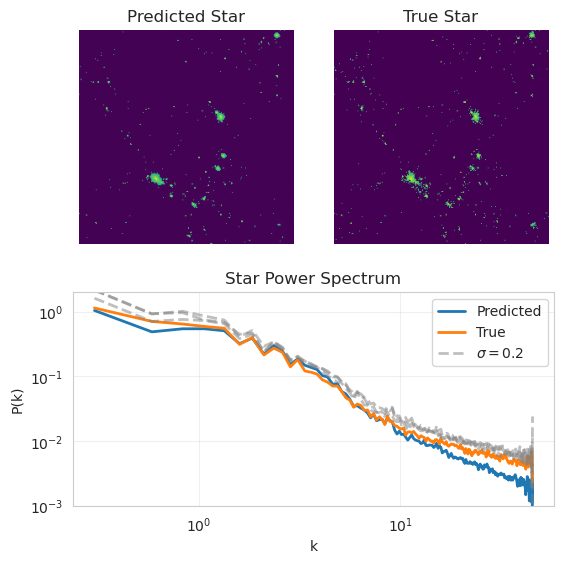

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 10

# Create figure and axes grid
fig = plt.figure(figsize=(6, 6))

# Top row: images
ax_pred = plt.subplot2grid((2, 4), (0, 0), colspan=2)
ax_true = plt.subplot2grid((2, 4), (0, 2), colspan=2)

# Bottom row: power spectrum
ax_star = plt.subplot2grid((2, 4), (1, 0), colspan=4)

# Plot predicted star image
ax_pred.imshow(pred_star, cmap='viridis')
ax_pred.set_title("Predicted Star")
ax_pred.axis('off')

# Plot true star image
ax_true.imshow(true_star, cmap='viridis')
ax_true.set_title("True Star")
ax_true.axis('off')

# Plot power spectra
ax_star.loglog(k_pred_star, Pk_pred_star, label="Predicted", linewidth=2)
ax_star.loglog(k_true_star, Pk_true_star, label="True", linewidth=2)

# Add noisy spectra
for i, (k, pk) in enumerate(noisy_star_pk):
    label = r'$\sigma=0.2$' if i == 0 else None  # avoid duplicate labels
    ax_star.loglog(k, pk, linewidth=2, alpha=0.5, ls='--', color='gray', label=label)

ax_star.set_title("Star Power Spectrum")
ax_star.set_xlabel("k")
ax_star.set_ylabel("P(k)")
ax_star.set_ylim(1e-3, 2)
ax_star.legend()
ax_star.grid(True, alpha=0.3)

plt.tight_layout(pad=2.0)
plt.savefig("sample_noise.png", dpi=300, bbox_inches='tight')
plt.show()
